In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%autosave 0
%matplotlib inline

Autosave disabled


# Neural Networks

Neural networks are models inspired by the workings of the human brain and the ability of brains to learn and adapt.  Neural networks build on the foundations of humble linear models like the perceptron and logistic regression.

### Recap: linear models

In previous notebooks we have discussed the use of linear functions to make predictions:

$$ f(\textbf{x}) = \textbf{w}^T \textbf{x} + b $$

For classification, the class associated with $\textbf{x}$ is decided according to whether $f(\textbf{x})$ is above or below some threshold, usually zero.

These models work well when the classification problem is close to being linearly separable.  To illustrate this we will use logistic regression.  One slight change has been made to the `logistic_regression` class from previous notebooks - rather than initializing the weights to zero, their values are initialized to small, normally-distributed numbers.

In [2]:
def sigmoid(s):
    return 1/(1+np.exp(-s))
def sigmoid_derivative(s):
    return np.multiply(sigmoid(s), (1-sigmoid(s)))

class logistic_regression:
    def __init__(self, lr=0.01, change=0.0001):
        self.lr = lr
        self.change = change

    def decision_function(self, X):
        return 1/(1+np.exp(-np.inner(self.w, X)))

    def gradient(self, X, y): 
        return (self.decision_function(X) - y)@X/len(X)
  
    def loss(self, X, y):
        pred = self.decision_function(X) 
        loss_values = - y * np.log(pred) - (1 - y) * np.log(1 - pred)
        return np.mean(loss_values) 
  
    def fit(self, X, y): 
        self.w = np.random.normal(0, 0.1, X.shape[1])
        loss = self.loss(X, y)
        self.loss_history = [loss]
        change = 1       
        while(change > self.change):
            old_loss = loss
            self.w = self.w - self.lr * self.gradient(X, y)
            loss = self.loss(X, y)
            self.loss_history.append(loss)
            change = old_loss - loss
         
    def predict(self, X): 
        pred_prob = self.decision_function(X) 
        pred_class = np.where(pred_prob >= .5, 1, 0) 
        return np.squeeze(pred_class) 


Here's an illustration of logistic regression for data generated using the scikit-learn `make_classification` method:

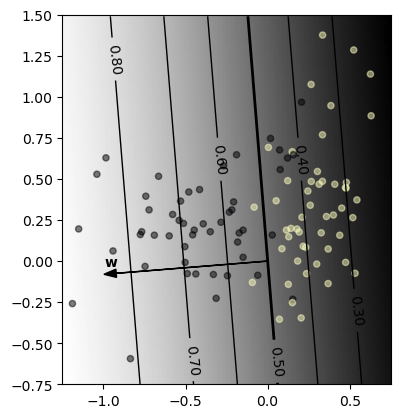

In [3]:
from sklearn.datasets import make_classification
X,y = make_classification(n_samples=100, n_features=2, n_informative=2, n_redundant=0, n_repeated=0, n_classes=2, n_clusters_per_class=1, class_sep=0.3, random_state=1)
lgr=logistic_regression()
lgr.fit(X, y)
y_pred=lgr.predict(X)

plt.style.use('default')
plt.scatter(X[:,0], X[:,1], c=1-y, alpha=0.5, s=20, cmap='magma');

w = lgr.w/np.linalg.norm(lgr.w)

delta = 0.01
xmin=-1.25;xmax=0.75;ymin=-0.75;ymax=1.5
xs = np.arange(xmin, xmax, delta)
ys = np.arange(ymin, ymax, delta)
x_grid, y_grid = np.meshgrid(xs, ys)

Z = sigmoid(lgr.w[0]*x_grid + lgr.w[1]*y_grid)

im = plt.imshow(Z, origin='lower',
                cmap=plt.cm.gray, extent=(xmin,xmax,ymin,ymax) )

C = plt.contour(x_grid, y_grid, Z, 7, 
                origin='lower',
                linewidths=(1,1,1,1,2,1,1),
                colors = 'black')

plt.clabel(C, inline=1, fmt='%1.2f')

plt.arrow(0,0,w[0],w[1], width=0.001,head_width=0.05, length_includes_head=True, alpha=1,linestyle='-',color='k');
plt.text(w[0], w[1]+0.05, r"$\mathbf{w}$");


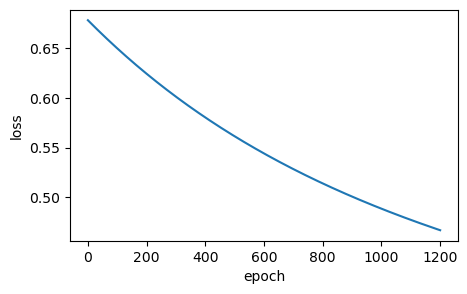

In [4]:
plt.figure(figsize=(5,3))
plt.plot(lgr.loss_history)
plt.ylabel('loss')
plt.xlabel('epoch');

## Nonlinear problems

However, these linear models do not always work - consider for example the XOR problem, which is a canonical example of a problem that is not linearly separable:

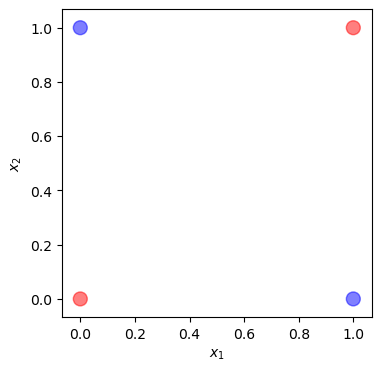

In [11]:
X = np.array([[0, 0], [1, 0], [0, 1], [1, 1]])
y = np.array([1, 0, 0, 1])

plt.figure(figsize=(4,4))
plt.scatter(X[:,0], X[:,1], c=y, s=100, alpha=0.5, cmap='bwr');
plt.xlabel('$x_1$')
plt.ylabel('$x_2$');

There is no line we can draw in the plane to successfully seperate the positive and negative examples, so when we try to classify with logistic regression, it fails:

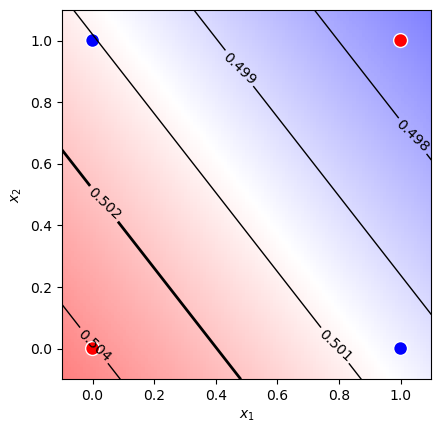

In [13]:
X = np.array([[0, 0], [1, 0], [0, 1], [1, 1]])
X = np.hstack((X, np.ones((4, 1)))) # Add the bias terms to the inputs to the regression model
y = np.array([1, 0, 0, 1])
lgr = logistic_regression(change=0.00000001)
lgr.fit(X, y)
y_pred=lgr.predict(X)

w = lgr.w/np.linalg.norm(lgr.w)

delta = 0.01
xmin=-0.1;xmax=1.1;ymin=-0.1;ymax=1.1 # Note that y here referes to the y axis, rather than the class labels
xs = np.arange(xmin, xmax, delta)
ys = np.arange(ymin, ymax, delta)
x_grid, y_grid = np.meshgrid(xs, ys)

Z = sigmoid(lgr.w[0]*x_grid + lgr.w[1]*y_grid + lgr.w[2]*1)

im = plt.imshow(Z, origin='lower',
                cmap=plt.cm.bwr, alpha=0.5, extent=(xmin,xmax,ymin,ymax))

C = plt.contour(x_grid, y_grid, Z, 7, 
                origin='lower',
                linewidths=(1,1,1,1,2,1,1),
                colors = 'black')


plt.scatter(X[:,0], X[:,1], c=y, s=100, cmap='bwr', edgecolors='w');
plt.clabel(C, inline=1)


plt.xlabel('$x_1$')
plt.ylabel('$x_2$');

### Recap: the perceptron

The perceptron was our first linear classifier.  It used the following rule:

$$f(\textbf{x}) = \text{step}(\textbf{w}^T \textbf{x} + b)$$

where $\text{step}$ refers to the step function

$$\text{step}(x) = \begin{cases} 1 & x \geq 0 \\ 0 & x < 0 \end{cases} $$

Previously we used the sign function because for convenience we used $\pm 1$ as the labels.
The only difference from the logistic regression model is the use of the step function rather than the sigmoid function.

Given features that are "good enough" - i.e. features that render the problem linearly separable, the perceptron can solve any classification problem.


Unfortunately, finding these features is not trivial, which was a major criticism of perceptrons in Minsky and Paperts 1969 book *Perceptrons*, which demonstrated that, given the understanding of the time, perceptrons could not do much.  Fortunately, McClelland, Rumelhart, and Hinton showed in 1986 in that by using "multilayer perceptrons" addresses this issue.

### Multi-layer perceptrons

A multi-layer perceptron (MLP) is a classifier that consists of at least three layers of nodes:  an input layer, a hidden layer and an output layer.
The input layer receives the input, while each subsequent layer computes a function of the previous layer (usually nonlinear).  The output layer produces the resulting prediction of the MLP.  Here is an example:

<img style="padding:10px;width:50%;" alt="Simple multilayer perceptron architecture" src="figures/simple_network.png">

First we'll consider an architecture where each node is a perceptron. Here, we have two red nodes, $h_1$ and $h_2$, that represent perceptrons with

$$ h_1(\textbf{x}) = \text{step}(\textbf{w}_1^T \textbf{x} + b_1) $$
and
$$ h_2(\textbf{x}) = \text{step}(\textbf{w}_2^T x + \textbf{b}_2). $$

Next, $h_1$ and $h_2$ are used as inputs to another perceptron, $f$.  For this perceptron, we'll drop the step function:

$$ f(\textbf{x}) = v_1 h_1(\textbf{x}) + v_2 h_2(\textbf{x}) + c $$
or
$$ f(\textbf{x}) = v_1 \text{step}(\textbf{w}_1^T \textbf{x} + b_1) + v_2 \text{step}(\textbf{w}_2^T \textbf{x} + b_2) + c. $$

It is useful to write this in vectorized form as

$$ f(\textbf{x}) = \textbf{v}^T \text{step}(\textbf{W} \textbf{x} + \textbf{b}) + c. $$

Here is such a multilayer perceptron that solves the XOR problem, followed by an illustration of its solution:

<img style="padding:10px;width:50%;" alt="Multilayer perceptron architecture for XOR" src="figures/xor_network.png">

Here,
\begin{align}
\textbf{W} &= \begin{bmatrix} 1 & 1 \\ 1 & 1 \end{bmatrix} \\
\textbf{b} &= \begin{bmatrix} -1.5 \\ -0.5 \end{bmatrix} \\
\textbf{v} &= \begin{bmatrix} 1 \\ -1 \end{bmatrix} \\
c &= 1
\end{align}

Let's plot it:

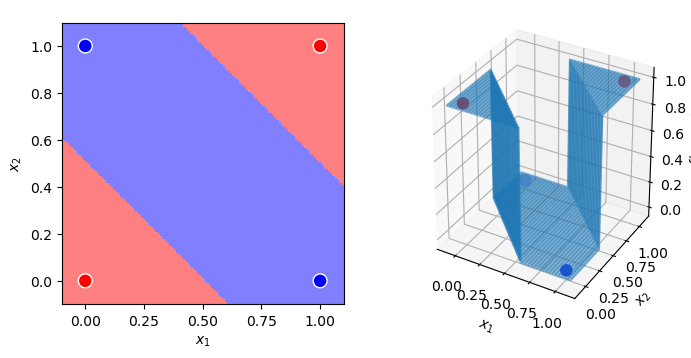

In [17]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection='3d')

W = np.array([[1, 1], [1, 1]])
b = np.array([[-1.5], [-0.5]])
v = np.array([1, -1])
c = 1

delta = 0.01
xmin=-0.1;xmax=1.1;ymin=-0.1;ymax=1.1
xs = np.arange(xmin, xmax, delta)
ys = np.arange(ymin, ymax, delta)
x_grid, y_grid = np.meshgrid(xs, ys)

xs = x_grid.reshape(-1)
ys = y_grid.reshape(-1)
x = np.vstack((xs, ys))

Z = np.dot(v, np.heaviside(np.matmul(W, x) + b, 1)) + c
Z = Z.reshape(x_grid.shape)

im = ax.imshow(Z, origin='lower',
                cmap=plt.cm.bwr, alpha=0.5, extent=(xmin,xmax,ymin,ymax) )

X = np.array([[0, 0], [1, 0], [0, 1], [1, 1]])
y = np.array([1, 0, 0, 1])

ax.scatter(X[:,0], X[:,1], c=y, s=100, cmap='bwr', edgecolors='w');
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

ax2.plot_wireframe(x_grid, y_grid, Z, alpha=0.5);
ax2.scatter(X[:,0], X[:,1], y, c=y, s=100, cmap='bwr', edgecolors='w')
ax2.set_xlabel('$x_1$')
ax2.set_ylabel('$x_2$')
ax2.set_zlabel('f($x_1$, $x_2$)');

You can verify that this multilayer perceptron compute $\mathrm{XOR}(x_1, x_2)$ as $\mathrm{OR}(x_1, x_2)-\mathrm{AND}(x_1, x_2)$.


## More complex architectures

The architecture described earlier, with two hidden nodes is perhaps  the simplest neural network architecture that can be constructed.  For added complexity you can add more hidden nodes:

<img style="padding:10px;width:50%;" alt="A wider multilayer perceptron" src="figures/wide_network.png">

In this architecture visualization $\textbf{x}$ represents any number of inputs to the network.

The set of hidden nodes before the output is known as the "hidden layer."  The number of nodes in that hidden layer is known as its "width."  In addition to adding nodes to that layer, we could alternatively add more hidden layers to increase the "depth".  Here's an example of a network with two hidden layers:

<img style="padding:10px;width:60%;" alt="A wider multilayer perceptron" src="figures/deeper_network.png">

This structure of successive layers is called a multilayer perceptron, and is also frequently referred to as a **fully-connected feedforward neural network**.  In general we can have any number of hidden layers and each hidden layer can have any number of neurons:

<img style="padding:10px;width:70%;" alt="A wider multilayer perceptron" src="figures/full_network.png">

Modern neural networks can to be very large both in depth and number of neurons per layer, which can add up to many parameters!

## Universal approximation

Neural networks being able to solve the XOR problem is great, but it doesn't mean they will be useful for problems in general.

Fortunately, it can be shown that there exists a neural network of some width and some depth that solves any well-behaved problem to arbitrary precision.  The ability to solve any problem is known as "universal approximation," and there are various universal approximation theorems that have demonstrated universal approximation for various network architectures.
If you are interested, [chapter 4 of Neural networks and Deep Learning](http://neuralnetworksanddeeplearning.com/chap4.html) shows a relatively simple visual proof that wide neural networks with sigmoidal activation functions can approximate arbitrary functions.

It is worth noting that a network with a single hidden layer is a universal approximator given sufficient width.

## Training a network

To actually train a network, we need some way of figuring out how to update the weights.  Simply applying the perceptron update rule no longer works --- it will successfully update the final layer, but the hidden neurons don't have a sense of a "correct" or "incorrect classification, so they cannot be updated in that way.

The method that is used instead is gradient descent - with a selection of an "activation function" (which in our previous example was the step function) and application of the chain rule, the weights can be updated according to their contribution to the final answer.  This process does require the activation function to be differentiable - meaning we need to choose an alternative to the step function.


### Activation functions

The activation function that was used most commonly from the mid 1980s to 2012 was the sigmoid and its sibling function, tanh, which is a rescaling of sigma from -1 to 1 instead of 0 to 1.  These can be considered as smooth versions of the step function, as they have the same behavior everywhere except near zero.

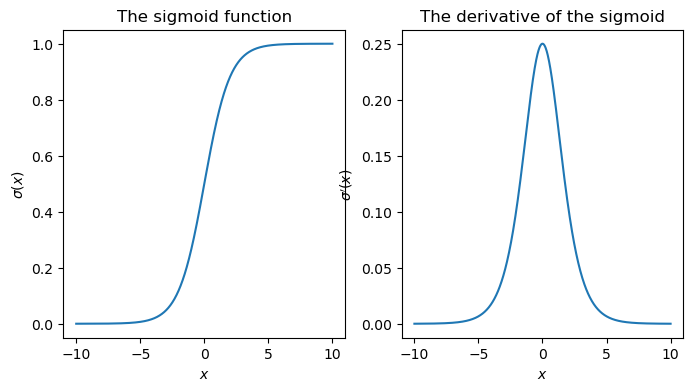

In [18]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

x = np.linspace(-10, 10, 1000)
y = sigmoid(x)

dy = sigmoid_derivative(x)

ax.plot(x, y)
ax.set_xlabel('$x$')
ax.set_ylabel('$\sigma(x)$')
ax.set_title('The sigmoid function')
ax2.plot(x, dy)
ax2.set_xlabel('$x$')
ax2.set_ylabel("$\sigma'(x)$")
ax2.set_title("The derivative of the sigmoid");

However, the sigmoid functions fell out of favor in 2012 due to their "vanishing gradient."  As visible in the plot of the derivative, as the input to the sigmoid increases in magnitude, the derivative approaches zero rapidly.  This means that if a hidden neuron in the network recieves a large input, the derivative to the weights resulting from that input will be very small.  This isn't typically a significant issue for small networks, but for modern networks that have many layers, it can become difficult to train the network effectively.  Another reason that sigmoids have fallen out of favor is that evaluating them computationally is (relatively) slow.

With the advent of "deep learning," the activation function that is used more commonly is the Rectified Linear Unit or ReLU.  ReLU is defined as

$$ \text{ReLU}(x) = \begin{cases} x, & x \geq 0 \\ 0, & x < 0 \end{cases} $$
which means that its derivative is
$$ \text{ReLU}'(x) = \begin{cases} 1, & x > 0 \\ 0, & x < 0 \end{cases} $$
with the derivative at zero being somewhat arbitrary (typically a value of 0, 0.5, or 1 is chosen) due to the piecewise nature of the function.

In [19]:
def ReLU(x):
    return np.maximum(0, x)

def ReLU_derivative(x):
    dy = np.ones(x.shape)
    dy[x<0] = 0
    return dy

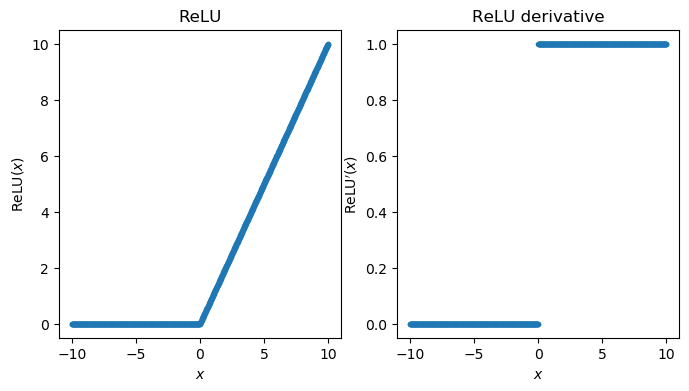

In [20]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

x = np.linspace(-10, 10, 1000)
y = ReLU(x)

dy = ReLU_derivative(x)

ax.plot(x, y, '.')
ax.set_xlabel('$x$')
ax.set_ylabel('ReLU$(x)$')
ax.set_title('ReLU')
ax2.plot(x, dy, '.')
ax2.set_xlabel('$x$')
ax2.set_ylabel("ReLU$'(x)$")
ax2.set_title("ReLU derivative");

### Gradient Descent


Our two layer network with two hidden neurons is defined as 

$$ f(\textbf{x}) = v_1 \sigma(\textbf{w}_1^T \textbf{x} + b_1) + v_2 \sigma(\textbf{w}_2^T \textbf{x} + b_2) + c $$
or
$$ f(\textbf{x}) = v_1 \sigma(w_{11}x_1 + w_{12}x_2 + b_1) + v_2 \sigma(w_{21}x_1 + w_{22}x_2 + b_2) + c. $$

From now on we will use $\sigma$ to refer to any activation function, not necessarily the sigmoid function.

Next, we need a loss function that defines the errors of our network.  One of the simplest loss functions is Euclidean distance from the correct answer, or, for a single output network

$$ L(\textbf{x}, y) = (f(\textbf{x}) - y)^2. $$

In order to 
The derivative of this with respect to $v_1$ is 
\begin{align*}
\frac{\partial L(\textbf{x}, y)}{\partial v_1} &= \frac{\partial}{\partial v_1} (f(\textbf{x}) - y)^2 \\
                                               &= 2(f(\textbf{x}) - y) * \frac{\partial}{\partial v_1} f(\textbf{x}) \qquad \text{from the chain rule} \\
                                               &= 2(f(\textbf{x}) - y) * \frac{\partial}{\partial v_1} \left(v_1 \sigma(\textbf{w}_1^T \textbf{x} + b_1) + v_2 \sigma(\textbf{w}_2^T \textbf{x} + b_2) + c\right) \qquad \text{substituting in the network definition}\\
                                               &= 2(f(\textbf{x}) - y) * \frac{\partial}{\partial v_1} v_1 \sigma(\textbf{w}_1^T \textbf{x} + b_1) \qquad \text{removing terms that don't vary in $v_1$}\\
                                               &= 2(f(\textbf{x}) - y) * \sigma(\textbf{w}_1^T \textbf{x} + b_1)
\end{align*}

and similarly for $v_2$ and $c$, so
\begin{align*}
\frac{\partial L(\textbf{x}, y)}{\partial v_1} &= 2(f(\textbf{x}) - y) * \sigma(\textbf{w}_1^T \textbf{x} + b_1) \\
\frac{\partial L(\textbf{x}, y)}{\partial v_2} &= 2(f(\textbf{x}) - y) * \sigma(\textbf{w}_2^T \textbf{x} + b_2) \\
\frac{\partial L(\textbf{x}, y)}{\partial c} &= 2(f(\textbf{x}) - y)
\end{align*}

The derivative of the loss with respect to $w_{11}$ is
\begin{align*}
\frac{\partial L(\textbf{x}, y)}{\partial w_{11}} &= \frac{\partial}{\partial w_{11}} (f(\textbf{x}) - y)^2 \\
                                               &= 2(f(\textbf{x}) - y) * \frac{\partial}{\partial w_{11}} f(\textbf{x})\\
                                               &= 2(f(\textbf{x}) - y) * \frac{\partial}{\partial w_{11}} \left(v_1 \sigma(w_{11}x_1 + w_{12}x_2 + b_1) + v_2 \sigma(w_{21}x_1 + w_{22}x_2 + b_2) + c\right) \\
                                               &= 2(f(\textbf{x}) - y) * \frac{\partial}{\partial w_{11}} v_1 \sigma(w_{11}x_1 + w_{12}x_2 + b_1) \\
                                               &= 2(f(\textbf{x}) - y) * v_1 \frac{\partial}{\partial w_{11}}  \sigma(w_{11}x_1 + w_{12}x_2 + b_1) \\
                                               &= 2(f(\textbf{x}) - y) * v_1 * \sigma'(w_{11}x_1 + w_{12}x_2 + b_1) * x_1
\end{align*}
and so therefore
\begin{align*}
\frac{\partial L(\textbf{x}, y)}{\partial v_1} &= 2(f(\textbf{x}) - y) * \sigma(\textbf{w}_1^T \textbf{x} + b_1) \\
\frac{\partial L(\textbf{x}, y)}{\partial v_2} &= 2(f(\textbf{x}) - y) * \sigma(\textbf{w}_2^T \textbf{x} + b_2) \\
\frac{\partial L(\textbf{x}, y)}{\partial c} &= 2(f(\textbf{x}) - y) \\
\frac{\partial L(\textbf{x}, y)}{\partial w_{11}} &= 2(f(\textbf{x}) - y) * v_1 * \sigma'(\textbf{w}_1^T \textbf{x} + b_1) * x_1 \\
\frac{\partial L(\textbf{x}, y)}{\partial w_{12}} &= 2(f(\textbf{x}) - y) * v_1 * \sigma'(\textbf{w}_1^T \textbf{x} + b_1) * x_2 \\
\frac{\partial L(\textbf{x}, y)}{\partial b_{1}} &= 2(f(\textbf{x}) - y) * v_1 * \sigma'(\textbf{w}_1^T \textbf{x} + b_1) \\
\frac{\partial L(\textbf{x}, y)}{\partial w_{21}} &= 2(f(\textbf{x}) - y) * v_2 * \sigma'(\textbf{w}_2^T \textbf{x} + b_2) * x_1 \\
\frac{\partial L(\textbf{x}, y)}{\partial w_{22}} &= 2(f(\textbf{x}) - y) * v_2 * \sigma'(\textbf{w}_2^T \textbf{x} + b_2) * x_2 \\
\frac{\partial L(\textbf{x}, y)}{\partial b_{2}} &= 2(f(\textbf{x}) - y) * v_2 * \sigma'(\textbf{w}_2^T \textbf{x} + b_2) \\
\end{align*}

This process of updating the weights is known as "backpropagation," as the derivative is propagated backwards through the network to determine the update rule for the weights.

### Exercise (challenge)

This works for a small network, but doing this for a larger network with more layers would be tedious.  How might you vectorize the calculation of these gradients?  What would the equations be for those vectorized gradients?

Warning: much of these calculations becomes an exercise in (potentially frustrating) notation - finding a solution online and working towards it is recommended if you choose to do this exercise.  The Neural Networks and Deep Learning book from the universal approximation section has a worked example that may be useful.

### Training on XOR

This class initializes, trains, and handles prediction for a simple two-node, single hidden layer neural network.

In [12]:
class neural_network:
    def __init__(self, lr=0.01, epochs=100):
        self.lr = lr
        self.epochs = epochs # How many times to update the weights based on gradient descent
        
        self.reset_weights() # Initialize the weights to small random values
        
        # Use ReLU for the network's activationf unction
        self.activation_function = ReLU
        self.activation_deriv = ReLU_derivative
        
    def reset_weights(self):
        self.W = np.random.normal(0, 0.1, (2, 2))
        self.b = np.random.normal(0, 0.1, (2, 1))
        self.v = np.random.normal(0, 0.1, (2))
        self.c = np.random.normal(0, 0.1, (1, 1))
        
        self.loss_history = []
        
    def decision_function(self, X):
        return np.dot(self.v, self.activation_function(np.matmul(self.W, X.T).reshape(2, -1) + self.b)) + self.c
        
    def update_gradient(self, X, y):
        # We are using gradient descent and not SGD
        # so we keep track of the old parameter values
        # in order to avoid updating the weights
        # and using those updated weights when we shouldn't
        oldW = np.copy(self.W)
        oldb = np.copy(self.b)
        oldv = np.copy(self.v)
        oldc = np.copy(self.c)
        
        for i in range(X.shape[0]):
            x = X[i, :]
            
            # Calculate quantities of interest for the given input sample
            pred = np.dot(oldv, self.activation_function(np.matmul(oldW, x).reshape(2, -1) + oldb)) + oldc
            loss_derivative = 2*(pred - y[i])
            node1 = self.activation_function(np.dot(oldW[0, :], x) + oldb[0])
            node1_derivative = self.activation_deriv(np.dot(oldW[0, :], x) + oldb[0])
            node2 = self.activation_function(np.dot(oldW[1, :], x) + oldb[1])
            node2_derivative = self.activation_deriv(np.dot(oldW[1, :], x) + oldb[1])

            # Update weights for this sample
            self.v[0] -= self.lr*loss_derivative*node1
            self.v[1] -= self.lr*loss_derivative*node2
            self.c -= self.lr*loss_derivative

            self.W[0, 0] -= self.lr*loss_derivative*oldv[0]*node1_derivative*x[0]
            self.W[0, 1] -= self.lr*loss_derivative*oldv[0]*node1_derivative*x[1]
            self.b[0] -= (self.lr*loss_derivative*oldv[0]*node1_derivative).reshape(-1)
            self.W[1, 0] -= self.lr*loss_derivative*oldv[1]*node2_derivative*x[0]
            self.W[1, 1] -= self.lr*loss_derivative*oldv[1]*node2_derivative*x[1]
            self.b[1] -= (self.lr*loss_derivative*oldv[1]*node2_derivative).reshape(-1)
  
    def loss(self, X, y):
        return np.mean((self.decision_function(X) - y)**2)
  
    def fit(self, X, y): 
        loss = self.loss(X, y)
        self.loss_history.append(loss)   
        
        for _ in range(self.epochs):
            self.update_gradient(X, y)
            loss = self.loss(X, y)
            self.loss_history.append(loss)
         
    def predict(self, X): 
        pred_prob = self.decision_function(X) 
        pred_class = np.where(pred_prob >= .5, 1, 0) 
        return np.squeeze(pred_class) 


This does the actual training of the network.  While testing this notebook, this training method found a correct solution about 20-30% of the time.

There are a few methods that could be used to increase that significantly - centering the inputs at zero with a standard deviation of one, allowing sign changes in the classification, or using a different loss function than Euclidean distance.

In [13]:
X = np.array([[0, 0], [1, 0], [0, 1], [1, 1]])
y = np.array([1, 0, 0, 1])
# We use a large number of epochs here because convergence can be slow
network = neural_network(lr=0.005, epochs=3000)

for i in range(100):
    network.reset_weights()
    network.fit(X, y)
    if np.sum(network.predict(X) == y) == 4:
        break
print('It took {} network trainings for a correct solution to be found.'.format(i+1))

It took 1 network trainings for a correct solution to be found.


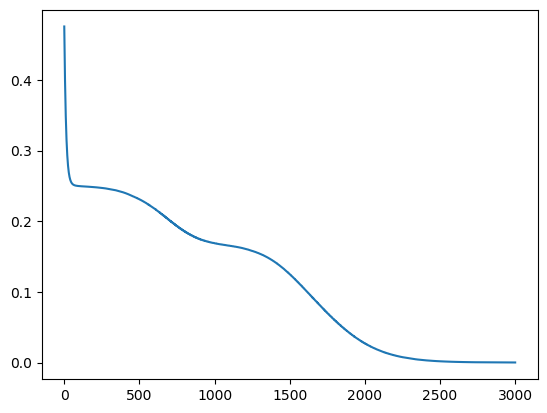

In [14]:
plt.plot(network.loss_history);

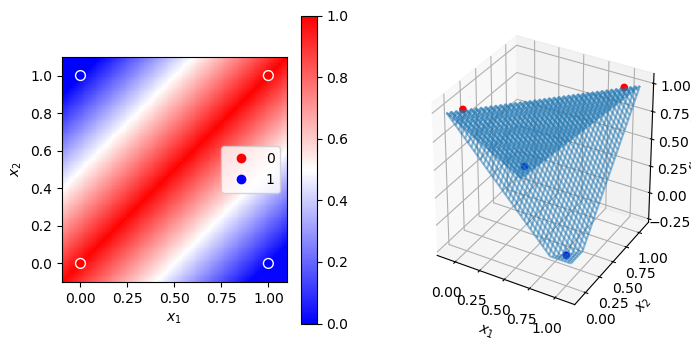

In [16]:
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection='3d')

delta = 0.01
xmin=-0.1;xmax=1.1;ymin=-0.1;ymax=1.1
xs = np.arange(xmin, xmax, delta)
ys = np.arange(ymin, ymax, delta)
x_grid, y_grid = np.meshgrid(xs, ys)

xs = x_grid.reshape(-1)
ys = y_grid.reshape(-1)
x = np.vstack((xs, ys))

Z = network.decision_function(x.T)
Z = Z.reshape(x_grid.shape)

im = ax.imshow(Z, origin='lower',
                cmap=plt.cm.bwr, extent=(xmin,xmax,ymin,ymax), vmin=0, vmax=1)

X = np.array([[0, 0], [1, 0], [0, 1], [1, 1]])
y = np.array([1, 0, 0, 1])

plt.style.use('default')
ax.scatter(X[:,0], X[:,1], c=y, s=50, cmap='bwr', edgecolors='w');
ax.plot([], [], 'or', label='0')
ax.plot([], [], 'ob', label='1')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.legend()

ax2.plot_wireframe(x_grid, y_grid, Z, alpha=0.5);
ax2.scatter(X[:,0], X[:,1], y, c=y, alpha=1, s=20, cmap='bwr')

ax2.set_xlabel('$x_1$')
ax2.set_ylabel('$x_2$')
ax2.set_zlabel('f($x_1$, $x_2$)');

### Exercise

Update the `neural_network` class to have at least one more node in its hidden layer.
* With more complexity, how does the frequency with which the training finds solutions that correctly classify all four points change?  For this specific problem, most of the issues in training come from poor initialization, but increasing network size can be beneficial to the training process in general.  Do be aware of the possibility of overfitting!
* What do solutions with more complex networks look like?

Challenge: add more layers (using vectorized updates as in the previous exercise would help with this, but is not necessary).  

## Comments

1. In practice, writing the update rules for a network is never done.  Packages are used that automatically apply the differentiation and allow for vastly more complex architectures than would be reasonable to do by hand.  We'll talk about one of these packages in future notebooks.
2. There are many more complex versions of neural network layers.  We will talk about a few in upcoming classes.

### Advantages of multilayer perceptrons/neural networks:

- Can solve any problem!
- Many features to tweak to perform correctly
- State-of-the-art in a variety of applications

### Disadvantages of multilayer perceptrons/neural networks:

- Difficult to interpret
- Large networks are frequently needed for success
- Selecting hyperparameters can be difficult

## References

Rosenblatt, Frank. "The perceptron: a probabilistic model for information storage and organization in the brain." Psychological review 65.6 (1958): 386.

Minsky, Marvin, et al. Perceptrons (MIT Press): An Introduction to Computational Geometry (The MIT Press). Reissue, MIT Press, 2017.

McClelland, James L., David E. Rumelhart, and PDP Research Group. "Parallel distributed processing." Explorations in the Microstructure of Cognition 2 (1986): 216-271

Michael A. Nielsen, "Neural Networks and Deep Learning", Determination Press, 2015.